## Three Stock Monte

This exercise tests your ability to retrieve stock price data using the Alpaca API and simulate multiple portfolio compositions using Monte Carlo Simulation.

### Import Dependencies

In [1]:
# Import libraries and dependencies
import os
import pandas as pd
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

### Get Past ~4 Year's Worth of Stock Price Data via Alpaca API Call

In [5]:
# Set timeframe to "1Day"
timeframe = "1Day"

# Set start and end datetimes between now and 4 years ago.
start_date = pd.Timestamp("2017-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-05-01", tz="America/New_York").isoformat()

# Set the ticker information
tickers = ["T","NKE","XOM"]

# Get 4 year's worth of historical price data
# HINT: Set "limit" to at least 10000 so all ticker rows are captured from get_bars()
df_ticker = api.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df


# Display sample data
df_ticker.head()

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2017-05-01 04:00:00+00:00,55.43,55.45,54.98,54.99,4881442,30491,55.201737,NKE
2017-05-02 04:00:00+00:00,55.12,55.16,54.79,55.07,7363885,41589,54.967165,NKE
2017-05-03 04:00:00+00:00,55.17,55.30,54.40,54.53,9486619,48477,54.622933,NKE
2017-05-04 04:00:00+00:00,54.68,54.83,54.20,54.47,6830628,39260,54.501544,NKE
2017-05-05 04:00:00+00:00,54.41,54.50,53.56,53.95,13379949,57959,53.889567,NKE


> Note: We're going to simulate five years of growth below, and so we might want to pull at least five years of data in order to do that. But we pulled four because of Alpaca's rate limits--we can only pull 1,000 rows per ticker at a time (approximately four years of data, with 252 tradable days per year). If we pull data with repeated calls in a `for` loop, however, we can get quite a few more years than what we've got above.  

In [6]:
# Reorganize the DataFrame
# Separate ticker data
T = df_ticker[df_ticker["symbol"]=="T"].drop("symbol", axis=1)
NKE = df_ticker[df_ticker["symbol"]=="NKE"].drop("symbol", axis=1)
XOM = df_ticker[df_ticker["symbol"]=="XOM"].drop("symbol", axis=1)

# Concatenate the ticker DataFrames
df_ticker = pd.concat([T, NKE, XOM], axis=1, keys=["T","NKE","XOM"])

# Display sample data
df_ticker.head()

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.68  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.14  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.41  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.08  38.71  38.03  38.56  21829853       82070   

                                        NKE                ...            \
                                vwap   open   high    low  ...    volume   
timestamp                                                  ...             
2017-05-01 04:00:00+00:00  39.278779  55.43  55.45  54.98  ...   4881442   
2017-05-02 04:00:00+00:00  38.996448  55.12  55.16  54.79  ...   7363885   
2017-05-03 04:00:00+00:00  38.423685  55.17  55.30  54.40  ...   9486619   
2017-05-04 04:00:00+00:00  37.965109  54.68  54.83  54.20  ...   6830628   
2017-05-05 04:00:00+00:00  38.424403  54.41  54.50  53.56  ...  13379949   

                                                    XOM                  \
                          trade_count       vwap   open     high    low   
timestamp                                                                 
2017-05-01 04:00:00+00:00       30491  55.201737  81.51  82.2100  81.48   
2017-05-02 04:00:00+00:00       41589  54.967165  82.14  82.5900  81.90   
2017-05-03 04:00:00+00:00       48477  54.622933  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00       39260  54.501544  82.29  82.3600  81.40   
2017-05-05 04:00:00+00:00       57959  53.889567  81.63  82.2350  81.61   

                                                                   
                           close    volume trade_count       vwap  
timestamp                                                          
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657  

[5 rows x 21 columns]

### Simulate five year portfolio growth with evenly-distributed stock investments

In [7]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns
MC_even_dist = MCSimulation(
    portfolio_data = df_ticker,
    weights = [.33,.33,.33],
    num_simulation = 1000,
    num_trading_days = 252*5
)

# Print the simulation input data
MC_even_dist.portfolio_data.head()

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.68  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.14  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.41  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.08  38.71  38.03  38.56  21829853       82070   

                                                     NKE         ...  \
                                vwap daily_return   open   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  39.278779          NaN  55.43  55.45  ...   
2017-05-02 04:00:00+00:00  38.996448    -0.003836  55.12  55.16  ...   
2017-05-03 04:00:00+00:00  38.423685    -0.014121  55.17  55.30  ...   
2017-05-04 04:00:00+00:00  37.965109    -0.010156  54.68  54.83  ...   
2017-05-05 04:00:00+00:00  38.424403     0.014470  54.41  54.50  ...   

                                                     XOM                  \
                                vwap daily_return   open     high    low   
timestamp                                                                  
2017-05-01 04:00:00+00:00  55.201737          NaN  81.51  82.2100  81.48   
2017-05-02 04:00:00+00:00  54.967165     0.001455  82.14  82.5900  81.90   
2017-05-03 04:00:00+00:00  54.622933    -0.009806  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00  54.501544    -0.001100  82.29  82.3600  81.40   
2017-05-05 04:00:00+00:00  53.889567    -0.009547  81.63  82.2350  81.61   

                                                                                
                           close    volume trade_count       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004          NaN  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909    -0.000122  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679     0.007922  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800    -0.012817  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657     0.004655  

[5 rows x 24 columns]

In [8]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
MC_even_dist.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\rwhit\onedrive\desktop\my_API_projects\APIs 3\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.997157,0.992190,0.992754,0.998759,0.999908,0.999422,1.024806,0.998320,1.018716,0.995014,...,0.995651,0.992659,0.994455,1.008848,1.008846,1.015306,0.993610,0.977262,1.002845,0.991509
2,0.968215,0.987267,0.970174,1.001606,0.985856,0.994474,1.030467,0.988946,1.009128,0.999289,...,1.002263,0.990238,0.986797,1.005055,1.022973,1.001064,0.998056,1.002189,0.994615,0.978506
3,0.964500,0.979601,0.965723,0.993582,0.986253,0.997935,1.024748,0.994088,1.005207,0.978433,...,1.002953,0.994765,0.985658,0.988565,1.021371,1.021173,0.999305,0.999547,0.980975,0.977482
4,0.971621,0.963389,0.939243,0.998109,0.995045,1.005818,1.033695,0.990186,1.029007,0.956448,...,1.005216,0.990324,0.964514,0.985856,1.017402,1.054649,0.992154,1.002256,0.983448,0.974004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.315141,0.744409,1.256440,0.996884,0.848386,1.363556,1.030604,1.031195,2.076845,0.976013,...,0.926001,1.571315,0.989414,1.582443,1.355238,1.125796,0.754306,1.356359,1.021019,1.525061
1257,1.302003,0.740467,1.260762,1.003913,0.855141,1.384129,1.037206,1.048239,2.090231,0.967927,...,0.911851,1.543643,0.989839,1.595928,1.348500,1.120594,0.743988,1.369802,1.030843,1.490805
1258,1.282769,0.736280,1.246521,1.006164,0.861763,1.370425,1.024875,1.056746,2.121090,0.967833,...,0.904148,1.528354,0.986518,1.599937,1.351614,1.117696,0.757268,1.373344,1.029811,1.497712
1259,1.261386,0.729194,1.251534,1.002743,0.859686,1.369069,1.020438,1.053948,2.132313,0.975828,...,0.910481,1.544187,1.002577,1.571675,1.364854,1.094348,0.752665,1.374256,1.010948,1.483423


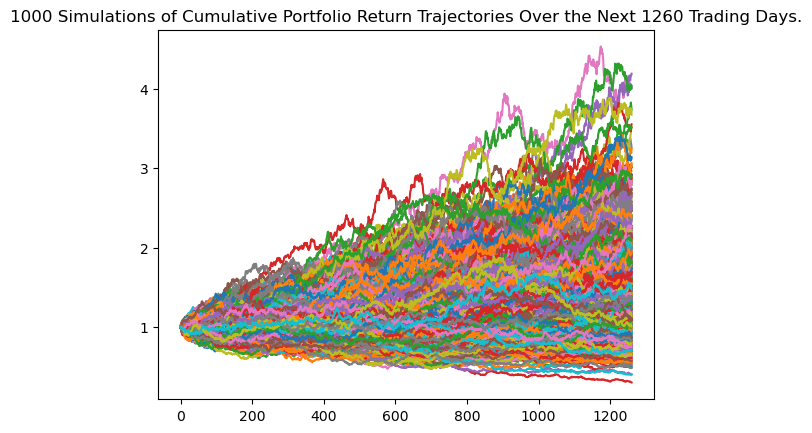

In [9]:
# Plot simulation outcomes
line_plot = MC_even_dist.plot_simulation()

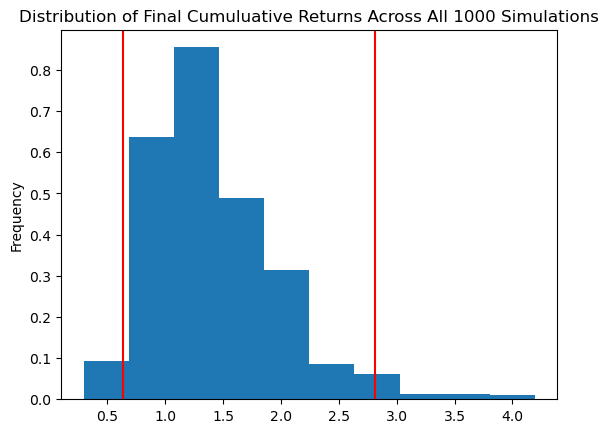

In [10]:
# Plot probability distribution and confidence intervals
dist_plot = MC_even_dist.plot_distribution()

In [11]:
# Fetch summary statistics from the Monte Carlo simulation results
even_tbl = MC_even_dist.summarize_cumulative_return()

# Print summary statistics
print(even_tbl)

count           1000.000000
mean               1.420413
std                0.561976
min                0.298114
25%                1.029202
50%                1.306571
75%                1.731336
max                4.194160
95% CI Lower       0.639253
95% CI Upper       2.813330
Name: 1260, dtype: float64


In [12]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments stocks
even_ci_lower = round(even_tbl[8]*15000,2)
even_ci_upper = round(even_tbl[9]*15000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $15,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${even_ci_lower} and ${even_ci_upper}.")

There is a 95% chance that an initial investment of $15,000 in the portfolio over the next 5 years will end within in the range of $9588.79 and $42199.95.


### Simulate five year portfolio growth with 60% AT&T stock

In [13]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
MC_att = MCSimulation(
    portfolio_data = df_ticker,
    weights = [.20,.60,.20],
    num_simulation = 1000,
    num_trading_days = 252*5)

# Print the simulation input data
MC_att.portfolio_data.head()

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.68  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.14  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.41  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.08  38.71  38.03  38.56  21829853       82070   

                                                     NKE         ...  \
                                vwap daily_return   open   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  39.278779          NaN  55.43  55.45  ...   
2017-05-02 04:00:00+00:00  38.996448    -0.003836  55.12  55.16  ...   
2017-05-03 04:00:00+00:00  38.423685    -0.014121  55.17  55.30  ...   
2017-05-04 04:00:00+00:00  37.965109    -0.010156  54.68  54.83  ...   
2017-05-05 04:00:00+00:00  38.424403     0.014470  54.41  54.50  ...   

                                                     XOM                  \
                                vwap daily_return   open     high    low   
timestamp                                                                  
2017-05-01 04:00:00+00:00  55.201737          NaN  81.51  82.2100  81.48   
2017-05-02 04:00:00+00:00  54.967165     0.001455  82.14  82.5900  81.90   
2017-05-03 04:00:00+00:00  54.622933    -0.009806  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00  54.501544    -0.001100  82.29  82.3600  81.40   
2017-05-05 04:00:00+00:00  53.889567    -0.009547  81.63  82.2350  81.61   

                                                                                
                           close    volume trade_count       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004          NaN  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909    -0.000122  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679     0.007922  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800    -0.012817  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657     0.004655  

[5 rows x 24 columns]

In [14]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
MC_att.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\rwhit\onedrive\desktop\my_API_projects\APIs 3\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.997639,0.990118,1.018664,1.017737,0.977555,0.993742,0.988711,0.983911,0.996014,1.007823,...,0.981799,0.994407,0.998035,0.999211,0.976621,0.998857,0.983800,1.000361,0.985514,1.000713
2,1.024253,0.990812,1.029374,1.031980,0.980418,0.985544,0.973550,1.003741,0.991473,0.981395,...,0.978593,0.982752,0.986178,1.007720,0.965298,1.013057,0.984471,1.004529,0.989840,1.014051
3,1.020547,0.996530,1.012824,1.027884,0.987004,0.995941,1.013569,0.995087,0.989684,0.963965,...,0.975400,0.984777,0.983452,1.021793,0.956389,1.014653,0.973071,0.984620,0.985803,1.023414
4,1.032426,0.994569,1.012628,1.032881,0.979092,0.986640,1.005608,0.981393,0.992957,0.961213,...,0.970949,0.977585,0.967268,1.033073,0.966518,1.029335,0.996939,0.986839,0.957241,1.025713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,0.989444,3.122022,1.487023,3.695716,2.999947,3.541619,1.473126,2.549716,1.950658,0.982750,...,1.443249,1.239250,2.170839,0.910818,1.190176,1.966186,1.541262,3.866794,1.239169,1.188110
1257,0.991677,3.201442,1.489818,3.722129,3.033529,3.515051,1.487736,2.588817,1.977476,0.992141,...,1.473581,1.248774,2.149907,0.904751,1.188514,1.980192,1.555319,3.823387,1.244462,1.179441
1258,0.996085,3.207406,1.499365,3.679752,3.083919,3.522695,1.495831,2.632900,1.959390,1.006279,...,1.483119,1.262629,2.093247,0.894387,1.182823,1.973277,1.542177,3.890247,1.251038,1.194001
1259,1.004166,3.193871,1.511119,3.664429,3.044457,3.521674,1.495314,2.638015,1.970676,0.993208,...,1.473356,1.255277,2.081418,0.897882,1.207306,2.014893,1.549875,3.913186,1.234029,1.200983


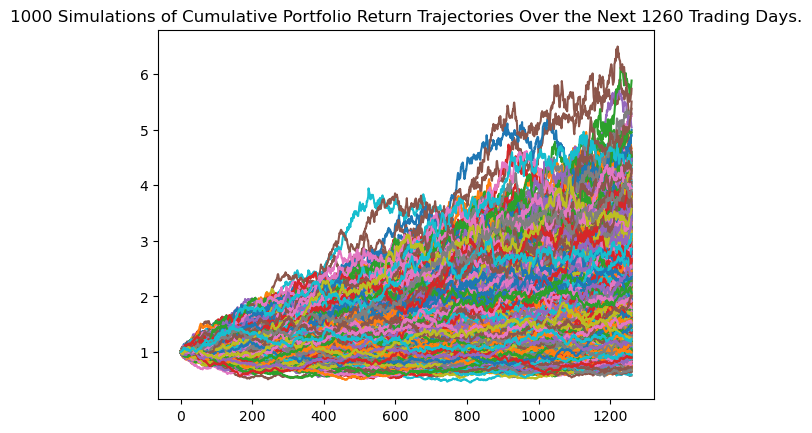

In [15]:
# Plot simulation outcomes
att_line_plot = MC_att.plot_simulation()

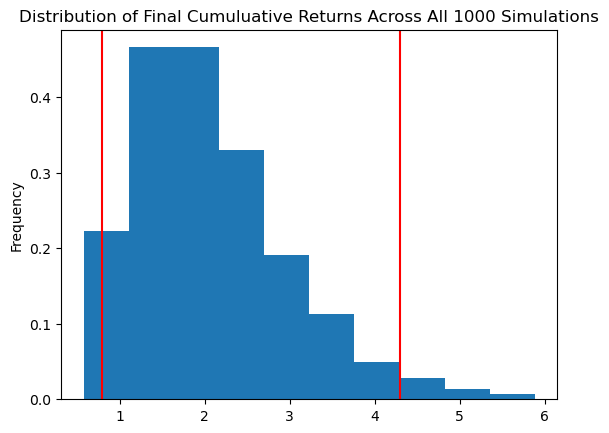

In [16]:
# Plot probability distribution and confidence intervals
att_dist_plot = MC_att.plot_distribution()

In [17]:
# Fetch summary statistics from the Monte Carlo simulation results
att_tbl = MC_att.summarize_cumulative_return()

# Print summary statistics
print(att_tbl)

count           1000.000000
mean               2.074163
std                0.901150
min                0.577856
25%                1.416304
50%                1.909288
75%                2.541530
max                5.882073
95% CI Lower       0.784884
95% CI Upper       4.292985
Name: 1260, dtype: float64


In [18]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
att_ci_lower = round(att_tbl[8]*15000,2)
att_ci_upper = round(att_tbl[9]*15000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $15,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${att_ci_lower} and ${att_ci_upper}.")

There is a 95% chance that an initial investment of $15,000 in the portfolio over the next 5 years will end within in the range of $11773.26 and $64394.77.


### Simulate five year portfolio growth with 60% Nike stock

In [19]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% Nike stock
MC_nike = MCSimulation(
    portfolio_data = df_ticker,
    weights = [.60,.20,.20],
    num_simulation = 1000,
    num_trading_days = 252*5
)

# Printing the simulation input data
MC_nike.portfolio_data.head()

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.68  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.14  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.41  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.08  38.71  38.03  38.56  21829853       82070   

                                                     NKE         ...  \
                                vwap daily_return   open   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  39.278779          NaN  55.43  55.45  ...   
2017-05-02 04:00:00+00:00  38.996448    -0.003836  55.12  55.16  ...   
2017-05-03 04:00:00+00:00  38.423685    -0.014121  55.17  55.30  ...   
2017-05-04 04:00:00+00:00  37.965109    -0.010156  54.68  54.83  ...   
2017-05-05 04:00:00+00:00  38.424403     0.014470  54.41  54.50  ...   

                                                     XOM                  \
                                vwap daily_return   open     high    low   
timestamp                                                                  
2017-05-01 04:00:00+00:00  55.201737          NaN  81.51  82.2100  81.48   
2017-05-02 04:00:00+00:00  54.967165     0.001455  82.14  82.5900  81.90   
2017-05-03 04:00:00+00:00  54.622933    -0.009806  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00  54.501544    -0.001100  82.29  82.3600  81.40   
2017-05-05 04:00:00+00:00  53.889567    -0.009547  81.63  82.2350  81.61   

                                                                                
                           close    volume trade_count       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004          NaN  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909    -0.000122  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679     0.007922  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800    -0.012817  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657     0.004655  

[5 rows x 24 columns]

In [20]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Nike stock
MC_nike.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\rwhit\onedrive\desktop\my_API_projects\APIs 3\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.013302,1.013186,0.998718,1.021563,1.002569,1.010633,0.998194,0.999252,0.992416,0.998523,...,1.028034,1.002573,0.985939,1.005130,1.013751,0.986991,0.997555,1.014729,1.006952,0.996593
2,1.029396,0.980381,1.017592,1.018806,1.001125,1.027505,0.991338,1.000372,0.981022,1.015063,...,1.030612,0.998891,0.999439,1.008419,0.999034,1.000239,1.006609,1.020776,1.010478,1.010443
3,1.033365,0.978998,1.007313,1.015134,0.986763,1.008631,0.993853,0.996769,0.989196,1.023141,...,1.024500,0.992848,1.003139,1.001611,1.016284,0.967701,1.017622,1.020143,1.022844,1.017182
4,1.020071,0.966519,1.020266,1.036896,0.996524,1.002362,1.007026,1.006757,0.976496,1.042642,...,1.041320,1.008247,1.008050,0.993352,1.016337,0.951785,1.017475,1.028051,1.019877,1.000407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.512902,1.605935,1.095669,0.815663,0.696051,1.209922,0.752608,2.094101,0.826984,0.850030,...,0.985090,2.275741,1.031318,0.619274,0.566268,0.709068,1.037185,1.857233,1.185441,0.818876
1257,1.527456,1.604157,1.115766,0.823944,0.700030,1.231762,0.754879,2.071529,0.821818,0.863406,...,0.978424,2.263343,1.024201,0.623949,0.567047,0.709140,1.050624,1.918558,1.166742,0.825000
1258,1.521591,1.605751,1.106784,0.829030,0.714517,1.212538,0.755311,2.036939,0.834027,0.860277,...,0.980699,2.267885,1.012352,0.625857,0.565953,0.731010,1.058007,1.914634,1.151452,0.844572
1259,1.525347,1.624397,1.103757,0.826533,0.704206,1.195154,0.747336,2.032003,0.830139,0.862562,...,0.991907,2.258659,1.001897,0.632944,0.560412,0.739060,1.069699,1.893667,1.173479,0.848878


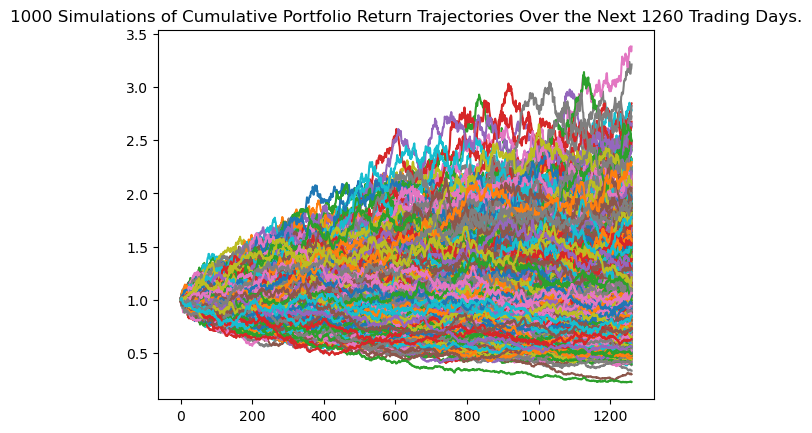

In [21]:
# Plot simulation outcomes
nike_line_plot = MC_nike.plot_simulation()

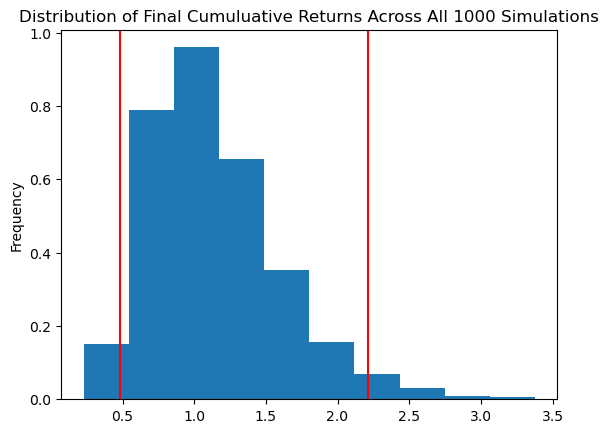

In [22]:
# Plot probability distribution and confidence intervals
nike_dist_plot = MC_nike.plot_distribution()

In [23]:
# Fetch summary statistics from the Monte Carlo simulation results
nike_tbl = MC_nike.summarize_cumulative_return()

# Print summary statistics
print(nike_tbl)

count           1000.000000
mean               1.140125
std                0.454101
min                0.230745
25%                0.803696
50%                1.062157
75%                1.384289
max                3.376669
95% CI Lower       0.482049
95% CI Upper       2.212789
Name: 1260, dtype: float64


In [24]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
nike_ci_lower = round(nike_tbl[8]*15000,2)
nike_ci_upper = round(nike_tbl[9]*15000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $15,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${nike_ci_lower} and ${nike_ci_upper}.")

There is a 95% chance that an initial investment of $15,000 in the portfolio over the next 5 years will end within in the range of $7230.74 and $33191.83.


### Simulate five year portfolio growth with 60% Exxon stock

In [25]:
# Configuring a Monte Carlo simulation to forecast five years cumulative returns
MC_exxon = MCSimulation(
    portfolio_data = df_ticker,
    weights = [.20,.20,.60],
    num_simulation = 1000,
    num_trading_days = 252*5)

# Printing the simulation input data
MC_exxon.portfolio_data

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.68  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.14  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.41  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.08  38.71  38.03  38.56  21829853       82070   
...                          ...    ...    ...    ...       ...         ...   
2021-04-26 04:00:00+00:00  31.38  31.38  30.89  30.91  45360916      135223   
2021-04-27 04:00:00+00:00  30.84  30.88  30.63  30.77  33200088      123035   
2021-04-28 04:00:00+00:00  30.97  31.15  30.90  30.96  27960327      105456   
2021-04-29 04:00:00+00:00  31.12  31.53  31.11  31.34  37758789      129297   
2021-04-30 04:00:00+00:00  31.36  31.43  31.05  31.41  31132760      103024   

                                                      NKE          ...  \
                                vwap daily_return    open    high  ...   
timestamp                                                          ...   
2017-05-01 04:00:00+00:00  39.278779          NaN   55.43   55.45  ...   
2017-05-02 04:00:00+00:00  38.996448    -0.003836   55.12   55.16  ...   
2017-05-03 04:00:00+00:00  38.423685    -0.014121   55.17   55.30  ...   
2017-05-04 04:00:00+00:00  37.965109    -0.010156   54.68   54.83  ...   
2017-05-05 04:00:00+00:00  38.424403     0.014470   54.41   54.50  ...   
...                              ...          ...     ...     ...  ...   
2021-04-26 04:00:00+00:00  31.027616    -0.015605  130.49  131.70  ...   
2021-04-27 04:00:00+00:00  30.742178    -0.004529  132.00  132.79  ...   
2021-04-28 04:00:00+00:00  31.009157     0.006175  132.27  132.29  ...   
2021-04-29 04:00:00+00:00  31.320009     0.012274  131.77  134.12  ...   
2021-04-30 04:00:00+00:00  31.287630     0.002234  132.44  133.88  ...   

                                                      XOM                  \
                                 vwap daily_return   open     high    low   
timestamp                                                                   
2017-05-01 04:00:00+00:00   55.201737          NaN  81.51  82.2100  81.48   
2017-05-02 04:00:00+00:00   54.967165     0.001455  82.14  82.5900  81.90   
2017-05-03 04:00:00+00:00   54.622933    -0.009806  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00   54.501544    -0.001100  82.29  82.3600  81.40   
2017-05-05 04:00:00+00:00   53.889567    -0.009547  81.63  82.2350  81.61   
...                               ...          ...    ...      ...    ...   
2021-04-26 04:00:00+00:00  130.887296     0.010830  55.62  56.2850  55.44   
2021-04-27 04:00:00+00:00  132.160411     0.003875  56.01  56.6300  55.81   
2021-04-28 04:00:00+00:00  130.802962    -0.010597  56.88  58.4600  56.79   
2021-04-29 04:00:00+00:00  132.969621     0.019509  58.92  59.4800  58.15   
2021-04-30 04:00:00+00:00  132.817825    -0.004803  58.33  58.8900  57.16   

                                                                                
                           close    volume trade_count       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004          NaN  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909    -0.000122  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679     0.007922  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800    -0.012817  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657     0.004655  
...                          ...       ...         ...        ...          ...  
2021-04-26 04:00:00+00:00  55.68  16034091       92919  55.853625     0.001979 

In [26]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Exxon stock
MC_exxon.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\rwhit\onedrive\desktop\my_API_projects\APIs 3\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002345,0.994028,1.026795,0.996941,0.999457,0.999671,0.993525,1.001975,1.000989,0.990029,...,1.004799,1.015257,0.960037,1.004154,1.003255,1.014748,0.997919,1.010713,1.013241,1.019137
2,0.993770,1.018371,1.036073,1.004313,1.002894,1.010502,0.971561,0.989343,0.989199,0.997658,...,1.012247,1.041382,0.963138,1.001355,0.999977,1.000646,1.002424,0.996213,1.030493,1.008778
3,0.987280,1.016798,1.024989,1.011412,0.996190,0.992950,0.960831,0.989599,1.010505,0.981813,...,1.007383,1.031971,0.993997,1.009141,1.003826,0.997157,1.004759,0.980791,1.040574,1.003484
4,0.995181,1.029486,0.994817,1.025883,1.000920,1.005357,0.937861,0.981212,1.030739,0.995974,...,1.007788,1.043842,0.984456,1.014927,1.009525,0.987886,0.988787,0.986202,1.013906,1.026177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.117873,1.052001,1.270983,1.010877,0.479058,0.878345,1.122599,0.820462,0.235679,1.462841,...,1.350121,2.123595,0.289936,0.813084,1.117892,0.891108,0.484247,1.112165,1.106134,0.634550
1257,1.111033,1.073408,1.268707,1.019880,0.485216,0.873501,1.145520,0.830612,0.234613,1.462206,...,1.340339,2.174002,0.290641,0.816426,1.111012,0.890085,0.485932,1.120677,1.079699,0.644998
1258,1.112133,1.060860,1.262300,1.013576,0.487707,0.879006,1.143291,0.824324,0.237470,1.474067,...,1.366630,2.219866,0.285498,0.814522,1.118374,0.905005,0.482070,1.142874,1.085491,0.637567
1259,1.135060,1.088576,1.252220,0.996590,0.490748,0.860986,1.147169,0.808294,0.243364,1.488953,...,1.346858,2.179235,0.286313,0.810445,1.124671,0.899008,0.489846,1.141868,1.083783,0.651329


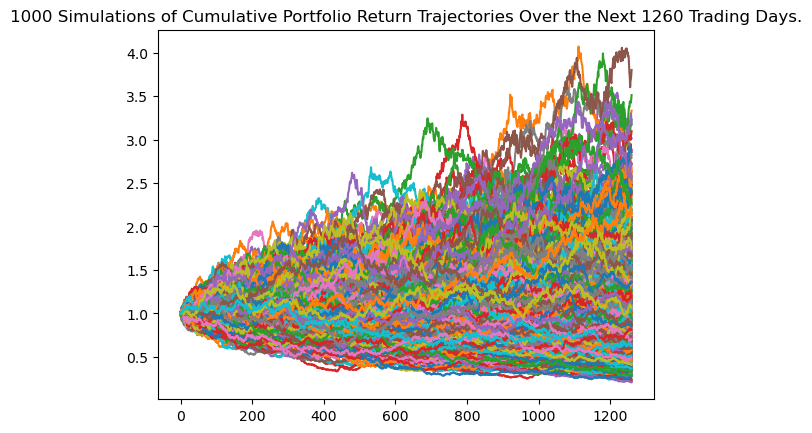

In [27]:
# Plot simulation outcomes
exxon_line_plot = MC_exxon.plot_simulation()

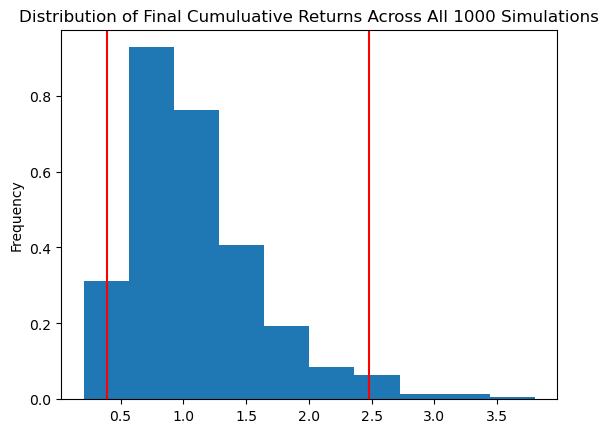

In [28]:
# Plot probability distribution and confidence intervals
exxon_dist_plot = MC_exxon.plot_distribution()

In [29]:
# Fetch summary statistics from the Monte Carlo simulation results
exxon_tbl = MC_exxon.summarize_cumulative_return()

# Print summary statistics
print(exxon_tbl)

count           1000.000000
mean               1.098111
std                0.528909
min                0.208540
25%                0.724740
50%                0.981325
75%                1.352080
max                3.799436
95% CI Lower       0.389126
95% CI Upper       2.481920
Name: 1260, dtype: float64


In [30]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
exxon_ci_lower = round(exxon_tbl[8]*15000,2)
exxon_ci_upper = round(exxon_tbl[9]*15000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $15,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${exxon_ci_lower} and ${exxon_ci_upper}.")

There is a 95% chance that an initial investment of $15,000 in the portfolio over the next 5 years will end within in the range of $5836.89 and $37228.8.


### Summarize findings across all 4 simulations

Looking across all four simulations, the portfolio breakdown with the greatest chance of success looks to be the portfolio with a majority of Nike stock. Although all four portfolios have a chance to lose money, the Nike portfolio is roughly the same level of risk with far more upside potential.

In [31]:
# Even weighted stocks
print("Even weighted stocks")
print(f"There is a 95% chance that an initial investment of $15,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${even_ci_lower} and ${even_ci_upper}.")
print("*"*50)

# 60% for AT&T
print("60% for AT&T")
print(f"There is a 95% chance that an initial investment of $15,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${att_ci_lower} and ${att_ci_upper}.")
print("*"*50)

# 60% for Nike
print("60% for Nike")
print(f"There is a 95% chance that an initial investment of $15,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${nike_ci_lower} and ${nike_ci_upper}.")
print("*"*50)

# 60% for Exxon
print("60% for Exxon")
print(f"There is a 95% chance that an initial investment of $15,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${exxon_ci_lower} and ${exxon_ci_upper}.")
print("*"*50)

Even weighted stocks
There is a 95% chance that an initial investment of $15,000 in the portfolio over the next 5 years will end within in the range of $9588.79 and $42199.95.
**************************************************
60% for AT&T
There is a 95% chance that an initial investment of $15,000 in the portfolio over the next 5 years will end within in the range of $11773.26 and $64394.77.
**************************************************
60% for Nike
There is a 95% chance that an initial investment of $15,000 in the portfolio over the next 5 years will end within in the range of $7230.74 and $33191.83.
**************************************************
60% for Exxon
There is a 95% chance that an initial investment of $15,000 in the portfolio over the next 5 years will end within in the range of $5836.89 and $37228.8.
**************************************************
